In [1]:
cd ..

/Users/muhammadfarooq/Codebase/wood-log-detection/Pith2Bark


In [2]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scikitplot as skplt

import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array

from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout

from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# Damage Dataset

In [3]:
def read_damage_min_max(damage_fname):
    df_damage = pd.read_csv(damage_fname)
    
    columns = ['min', 'max', 'mean', 'orig', 'diff_min_max', 'diff_orig_mean', 'damage_mean']
    df_damage_temp = df_damage.drop(columns=columns)
    df_damage_temp.rename(columns={'damage_min_max': 'Damage'}, inplace=True)

    df_damage_temp.reset_index(drop=True, inplace=True)

    return df_damage_temp

In [4]:
def read_damage_mean(damage_fname):
    df_damage = pd.read_csv(damage_fname)
    
    columns = ['min', 'max', 'mean', 'orig', 'diff_min_max', 'diff_orig_mean', 'damage_min_max']
    df_damage_temp = df_damage.drop(columns=columns)
    df_damage_temp.rename(columns={'damage_mean': 'Damage'}, inplace=True)

    df_damage_temp.reset_index(drop=True, inplace=True)

    return df_damage_temp

In [5]:
#damage
damage_url = "damage_dataset/damage.csv"

df_damage_min_max = read_damage_min_max(damage_url)

df_damage_mean = read_damage_mean(damage_url)

In [6]:
#STOP

In [7]:
df = df_damage_min_max

In [8]:
# set up the file paths for your image data and labels
img_size = (128, 128)

data_dir = 'damage_dataset/images'

# convert the DataFrame to a dictionary with specific column names as key and value
label_dict = {k: v for k, v in zip(df['image'], df['Damage'])}

# create empty lists to store the image data and labels
images = []
labels = []

# loop through each image file in the directory
for filename in os.listdir(data_dir):
    # load the image file and convert it to a NumPy array
    image = load_img(os.path.join(data_dir, filename), target_size=img_size)
    image = img_to_array(image)
    # preprocess the image by scaling the pixel values to be between 0 and 1
    image = image.astype('float32') / 255.0
    # add the preprocessed image and its label to the lists
    images.append(image)
    labels.append(label_dict[filename])

# convert the lists to NumPy arrays
images = np.array(images)
labels = np.array(labels)

# print the shape of the data to verify that it's been loaded correctly
print('Image data shape:', images.shape) #(148, 64, 64, 3)
print('Label data shape:', labels.shape) #(148,)

Image data shape: (148, 128, 128, 3)
Label data shape: (148,)


In [9]:
#STOP

# Config

In [10]:
training_percent = 0.9

epochs, batch_size = 50, 32
kf = KFold(n_splits=3, shuffle=True, random_state=42)

early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=10,
        restore_best_weights=True,
    )

METRICS = [
    tf.keras.metrics.TruePositives(name='tp'),
    tf.keras.metrics.FalsePositives(name='fp'),
    tf.keras.metrics.TrueNegatives(name='tn'),
    tf.keras.metrics.FalseNegatives(name='fn'), 
    tf.keras.metrics.BinaryAccuracy(name='accuracy'),
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall'),
    tf.keras.metrics.AUC(name='auc'),
    tf.keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

In [11]:
def heat_map_normalized(y_true, y_pred):
    
    class_names = ['Not Damage', 'Damaged']
    
    skplt.metrics.plot_confusion_matrix(y_true, y_pred,
                                        figsize=(4,3),
                                        normalize=True)
    
    # Customize axis tick labels
    plt.xticks([0,1], class_names)
    plt.yticks([0,1], class_names)
    
    plt.yticks(rotation=90)
    
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.show()

In [12]:
def heat_map(_cm):
    # plot confusion matrix as heatmap
    labels = ['Not Damage', 'Damaged']
    
    # Set up the matplotlib figure
    plt.figure(figsize=(4, 3))
    
    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(230, 20, as_cmap=True)
    
    sns.heatmap(_cm, annot=True, cmap=cmap, xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.show()

In [13]:
#STOP

# Model

In [14]:
class Baseline():
    def __init__(self, _input_dim, metrics=METRICS):
        # Define the model architecture
        model = Sequential()
        
        # convolutional layer
        model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=_input_dim))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.2))
                  
        # flatten output of conv
        model.add(Flatten())
                  
        # hidden layer
        model.add(Dense(64, activation='relu'))
        model.add(Dropout(0.2))
        
        # output layer         
        model.add(Dense(1, activation='sigmoid'))

        # Compile the model
        model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), metrics=metrics)

        self.model = model

    def train(self, X_train, y_train, X_val, y_val, epochs, batch_size):
        history = self.model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs, batch_size=batch_size, callbacks=[early_stopping], verbose=2)
        return history
    
    def evaluate(self, X_test, y_test):
        results = self.model.evaluate(X_test, y_test, verbose=0)
        return results

    def predict(self, X_test):
        predictions = self.model.predict(X_test)
        return predictions

    def summary(self):
        self.model.summary()
        
    def metrics_names(self):
        return self.model.metrics_names

# Prepare dataset

In [15]:
X = images
y = labels

# split the data into a holdout set and the rest for K-Fold cross-validation
X_train, X_holdout, y_train, y_holdout = train_test_split(X, y, train_size=training_percent, random_state=42)

In [16]:
input_dim = X_train.shape[1:]

model = Baseline(input_dim)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 63, 63, 32)        0         
                                                                 
 flatten (Flatten)           (None, 127008)            0         
                                                                 
 dense (Dense)               (None, 64)                8128576   
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                        

Epoch 1/50
3/3 - 2s - loss: 0.5992 - tp: 28.0000 - fp: 20.0000 - tn: 35.0000 - fn: 5.0000 - accuracy: 0.7159 - precision: 0.5833 - recall: 0.8485 - auc: 0.7661 - prc: 0.6814 - val_loss: 0.4258 - val_tp: 10.0000 - val_fp: 1.0000 - val_tn: 28.0000 - val_fn: 6.0000 - val_accuracy: 0.8444 - val_precision: 0.9091 - val_recall: 0.6250 - val_auc: 0.8114 - val_prc: 0.8142 - 2s/epoch - 680ms/step
Epoch 2/50
3/3 - 1s - loss: 0.4166 - tp: 22.0000 - fp: 1.0000 - tn: 54.0000 - fn: 11.0000 - accuracy: 0.8636 - precision: 0.9565 - recall: 0.6667 - auc: 0.8507 - prc: 0.8185 - val_loss: 0.5443 - val_tp: 10.0000 - val_fp: 5.0000 - val_tn: 24.0000 - val_fn: 6.0000 - val_accuracy: 0.7556 - val_precision: 0.6667 - val_recall: 0.6250 - val_auc: 0.8093 - val_prc: 0.8156 - 529ms/epoch - 176ms/step
Epoch 3/50
3/3 - 1s - loss: 0.4351 - tp: 24.0000 - fp: 4.0000 - tn: 51.0000 - fn: 9.0000 - accuracy: 0.8523 - precision: 0.8571 - recall: 0.7273 - auc: 0.8573 - prc: 0.8634 - val_loss: 0.4467 - val_tp: 10.0000 - val

Epoch 22/50
3/3 - 1s - loss: 0.2155 - tp: 25.0000 - fp: 0.0000e+00 - tn: 55.0000 - fn: 8.0000 - accuracy: 0.9091 - precision: 1.0000 - recall: 0.7576 - auc: 0.9860 - prc: 0.9822 - val_loss: 0.3915 - val_tp: 10.0000 - val_fp: 0.0000e+00 - val_tn: 29.0000 - val_fn: 6.0000 - val_accuracy: 0.8667 - val_precision: 1.0000 - val_recall: 0.6250 - val_auc: 0.8319 - val_prc: 0.8276 - 534ms/epoch - 178ms/step
Epoch 23/50
3/3 - 1s - loss: 0.2237 - tp: 24.0000 - fp: 0.0000e+00 - tn: 55.0000 - fn: 9.0000 - accuracy: 0.8977 - precision: 1.0000 - recall: 0.7273 - auc: 0.9796 - prc: 0.9746 - val_loss: 0.3887 - val_tp: 10.0000 - val_fp: 0.0000e+00 - val_tn: 29.0000 - val_fn: 6.0000 - val_accuracy: 0.8667 - val_precision: 1.0000 - val_recall: 0.6250 - val_auc: 0.8330 - val_prc: 0.8270 - 519ms/epoch - 173ms/step
Epoch 24/50
3/3 - 1s - loss: 0.2069 - tp: 25.0000 - fp: 0.0000e+00 - tn: 55.0000 - fn: 8.0000 - accuracy: 0.9091 - precision: 1.0000 - recall: 0.7576 - auc: 0.9909 - prc: 0.9859 - val_loss: 0.3960

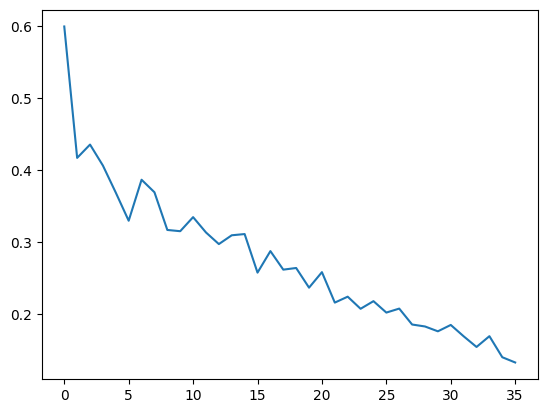

loss :  0.37032952904701233
tp :  10.0
fp :  0.0
tn :  29.0
fn :  6.0
accuracy :  0.8666666746139526
Accuracy on validation set: 0.87
precision :  1.0
recall :  0.625
auc :  0.8480603694915771
prc :  0.840447187423706
Epoch 1/50
3/3 - 2s - loss: 0.5922 - tp: 22.0000 - fp: 15.0000 - tn: 76.0000 - fn: 21.0000 - accuracy: 0.7313 - precision: 0.5946 - recall: 0.5116 - auc: 0.7405 - prc: 0.6880 - val_loss: 0.5316 - val_tp: 13.0000 - val_fp: 1.0000 - val_tn: 21.0000 - val_fn: 9.0000 - val_accuracy: 0.7727 - val_precision: 0.9286 - val_recall: 0.5909 - val_auc: 0.7407 - val_prc: 0.7305 - 2s/epoch - 716ms/step
Epoch 2/50
3/3 - 1s - loss: 0.3745 - tp: 17.0000 - fp: 3.0000 - tn: 59.0000 - fn: 10.0000 - accuracy: 0.8539 - precision: 0.8500 - recall: 0.6296 - auc: 0.8226 - prc: 0.8067 - val_loss: 0.7620 - val_tp: 13.0000 - val_fp: 1.0000 - val_tn: 21.0000 - val_fn: 9.0000 - val_accuracy: 0.7727 - val_precision: 0.9286 - val_recall: 0.5909 - val_auc: 0.7231 - val_prc: 0.7255 - 519ms/epoch - 173ms/s

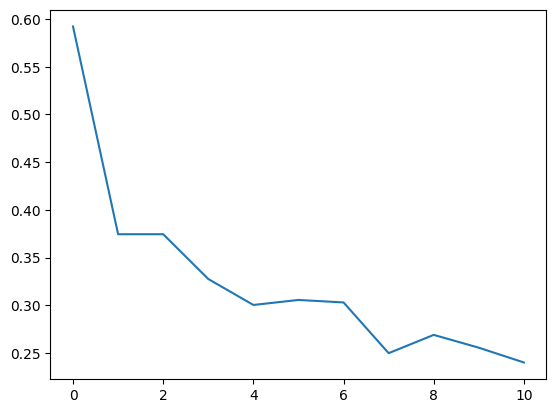

loss :  0.5315924286842346
tp :  13.0
fp :  1.0
tn :  21.0
fn :  9.0
accuracy :  0.7727272510528564
Accuracy on validation set: 0.77
precision :  0.9285714030265808
recall :  0.5909090638160706
auc :  0.7407024502754211
prc :  0.730484127998352
Epoch 1/50
3/3 - 2s - loss: 0.7614 - tp: 30.0000 - fp: 30.0000 - tn: 43.0000 - fn: 30.0000 - accuracy: 0.5489 - precision: 0.5000 - recall: 0.5000 - auc: 0.6189 - prc: 0.6308 - val_loss: 0.6756 - val_tp: 11.0000 - val_fp: 20.0000 - val_tn: 13.0000 - val_fn: 0.0000e+00 - val_accuracy: 0.5455 - val_precision: 0.3548 - val_recall: 1.0000 - val_auc: 0.9380 - val_prc: 0.8913 - 2s/epoch - 740ms/step
Epoch 2/50
3/3 - 1s - loss: 0.5989 - tp: 27.0000 - fp: 13.0000 - tn: 38.0000 - fn: 11.0000 - accuracy: 0.7303 - precision: 0.6750 - recall: 0.7105 - auc: 0.7882 - prc: 0.7594 - val_loss: 0.3363 - val_tp: 8.0000 - val_fp: 3.0000 - val_tn: 30.0000 - val_fn: 3.0000 - val_accuracy: 0.8636 - val_precision: 0.7273 - val_recall: 0.7273 - val_auc: 0.8540 - val_prc

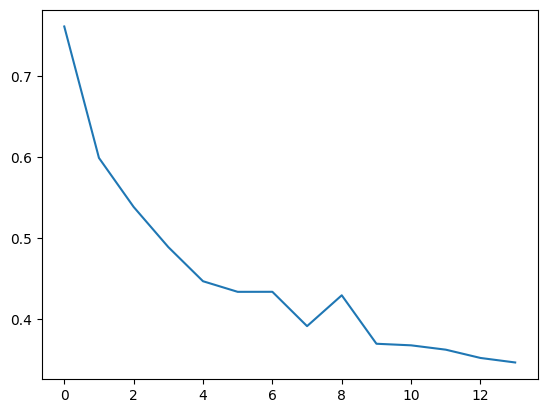

loss :  0.3034358620643616
tp :  8.0
fp :  1.0
tn :  32.0
fn :  3.0
accuracy :  0.9090909361839294
Accuracy on validation set: 0.91
precision :  0.8888888955116272
recall :  0.7272727489471436
auc :  0.844352662563324
prc :  0.8414880037307739
results [0.8666666746139526, 0.7727272510528564, 0.9090909361839294]
K-fold cross-validation accuracy: 0.85
1/1 [==============================] - 0s 90ms/step
Accuracy on holdout set: 0.87
Balanced Accuracy on holdout set: 0.85

Classification Report:

              precision    recall  f1-score   support

           0      0.900     0.900     0.900        10
           1      0.800     0.800     0.800         5

    accuracy                          0.867        15
   macro avg      0.850     0.850     0.850        15
weighted avg      0.867     0.867     0.867        15



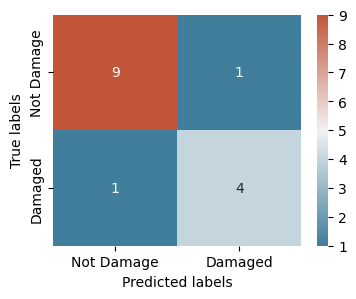

True Positive(TP)  =  4
False Positive(FP) =  1
True Negative(TN)  =  9
False Negative(FN) =  1
Accuracy of the binary classifier = 0.867


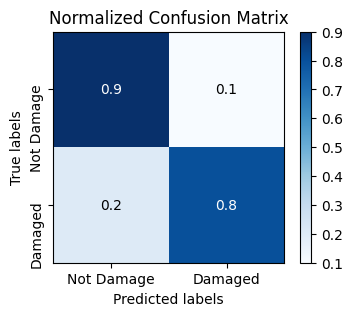

In [17]:
results = []

for train_index, val_index in kf.split(X_train):
    # split the dataset into training and validation sets for this fold
    X_train_kf, X_val_kf = X_train[train_index], X_train[val_index]
    y_train_kf, y_val_kf = y_train[train_index], y_train[val_index]
    
    model = Baseline(input_dim)
    
    history = model.train(X_train_kf, y_train_kf, X_val_kf, y_val_kf, epochs, batch_size)
    plt.plot(history.history['loss'])
    plt.show()
    
    results_m = model.evaluate(X_val_kf, y_val_kf)
    
    for name, value in zip(model.metrics_names(), results_m):
        print(name, ': ', value)
        if name == 'accuracy':
            accuracy_kf = value
            results.append(accuracy_kf)
            print(f"Accuracy on validation set: {accuracy_kf:.2f}")
    
# Calculate the average accuracy score for the K-fold cross-validation
print("results",results)
print(f"K-fold cross-validation accuracy: {sum(results) / len(results):.2f}")

y_pred_holdout = model.predict(X_holdout)
accuracy_holdout = accuracy_score(np.round(y_holdout), np.round(y_pred_holdout))
print(f"Accuracy on holdout set: {accuracy_holdout:.2f}")

balanced_accuracy_holdout = balanced_accuracy_score(np.round(y_holdout), np.round(y_pred_holdout))
print(f"Balanced Accuracy on holdout set: {balanced_accuracy_holdout:.2f}")

print("\nClassification Report:\n")
print(classification_report(np.round(y_holdout), np.round(y_pred_holdout), digits = 3))

cm = confusion_matrix(np.round(y_holdout), np.round(y_pred_holdout))
heat_map(cm)
TN, FP, FN, TP = confusion_matrix(np.round(y_holdout), np.round(y_pred_holdout)).ravel()
print('True Positive(TP)  = ', TP)
print('False Positive(FP) = ', FP)
print('True Negative(TN)  = ', TN)
print('False Negative(FN) = ', FN)

accuracy =  (TP + TN) / (TP + FP + TN + FN)
print('Accuracy of the binary classifier = {:0.3f}'.format(accuracy))

heat_map_normalized(np.round(y_holdout), np.round(y_pred_holdout))

In [18]:
# Calculate performance metrics
accuracy = accuracy_score(np.round(y_holdout), np.round(y_pred_holdout)) * 100
balanced_accuracy = balanced_accuracy_score(np.round(y_holdout), np.round(y_pred_holdout)) * 100
auc = roc_auc_score(np.round(y_holdout), np.round(y_pred_holdout))
precision = precision_score(np.round(y_holdout), np.round(y_pred_holdout))
recall = recall_score(np.round(y_holdout), np.round(y_pred_holdout))
f1 = f1_score(np.round(y_holdout), np.round(y_pred_holdout))

# Print results
print(f"Accuracy: {accuracy:.2f}%")
print(f"Balanced Accuracy: {balanced_accuracy:.2f}%")
print(f"AUC: {auc:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 score: {f1:.2f}")

Accuracy: 86.67%
Balanced Accuracy: 85.00%
AUC: 0.85
Precision: 0.80
Recall: 0.80
F1 score: 0.80


In [19]:
#STOP